In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

# Mogrifier LSTM

Mogrifier LSTM is a [paper](https://arxiv.org/pdf/1909.01792.pdf) out of Google Deep Mind published at ICLR in 2020. The paper proposes a modification to the LSTM network through the introduction of a gating mechanism for the input and previous hidden state. The paper goes on to show how this mogrifier mechanism (shown below) markedly improves over a baseline LSTM network and achieves SOTA on a number of small datasets such as Penn Tree Bank dataset and Wikitext-2 dataset. 

The interesting angle of this paper is the choice to focus on small scale datasets to explore how improving the architecture of a model can improve it's generalization and argue that many of the current models today are actually measured on their scability rather than generability. This argument makes intuitive sense to me, models/datasets keep getting bigger and performance gets better as a result. This and other research such as the SHA-RNN from Smerity et al is fascinating and has the added benefit of more rapid prototyping and experimentation due to the smaller model size.

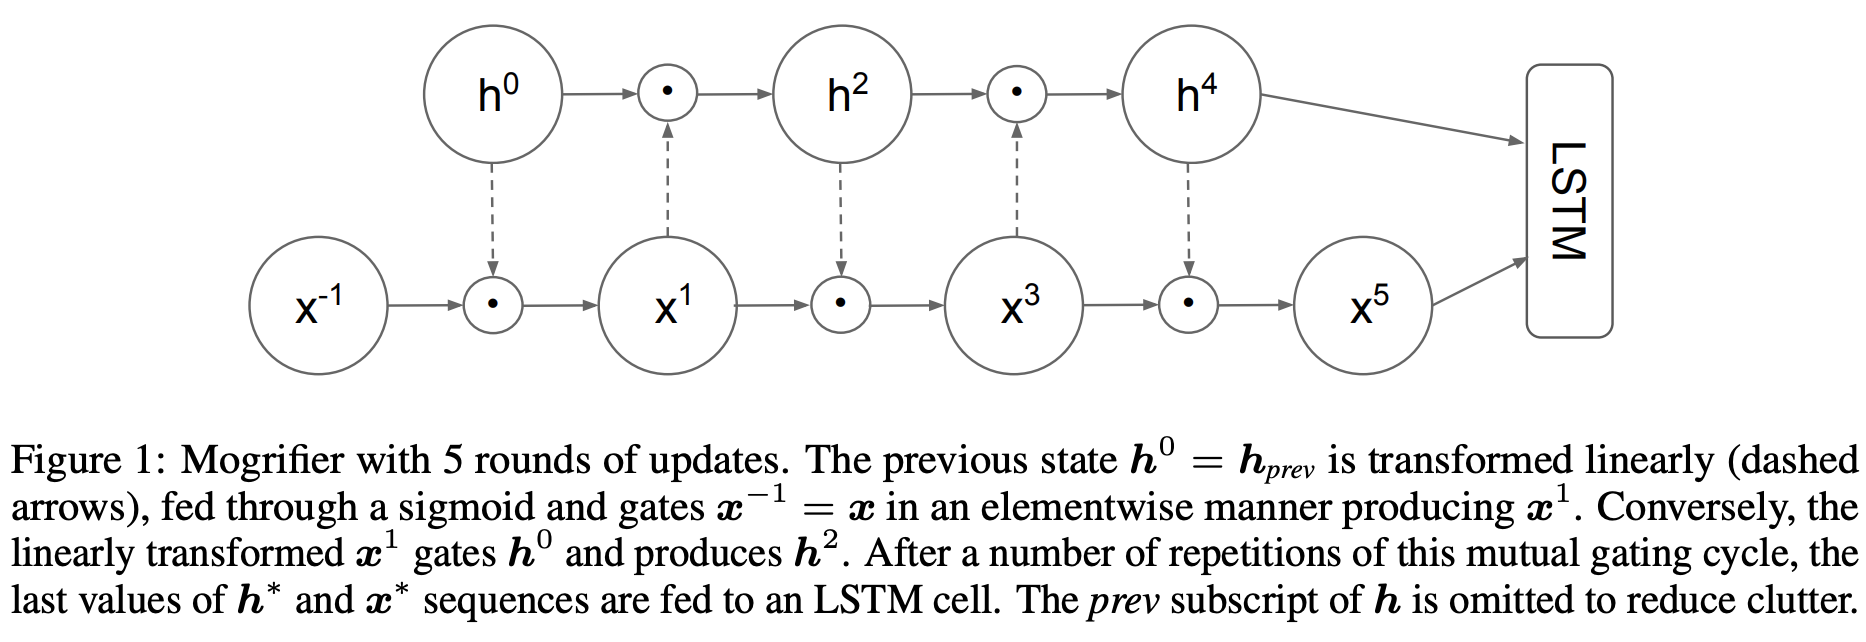

The one concern that I have with this paper, after an initial read through is that they achieve near SOTA performance with a regular LSTM via extensive hyperparameter tuning. The argument could be made that hyperparameter optimization is almost as important as the new architecture. Adding the mogrifier step improves perplexity by another 3-5 points which is nothing to be scoffed at. 

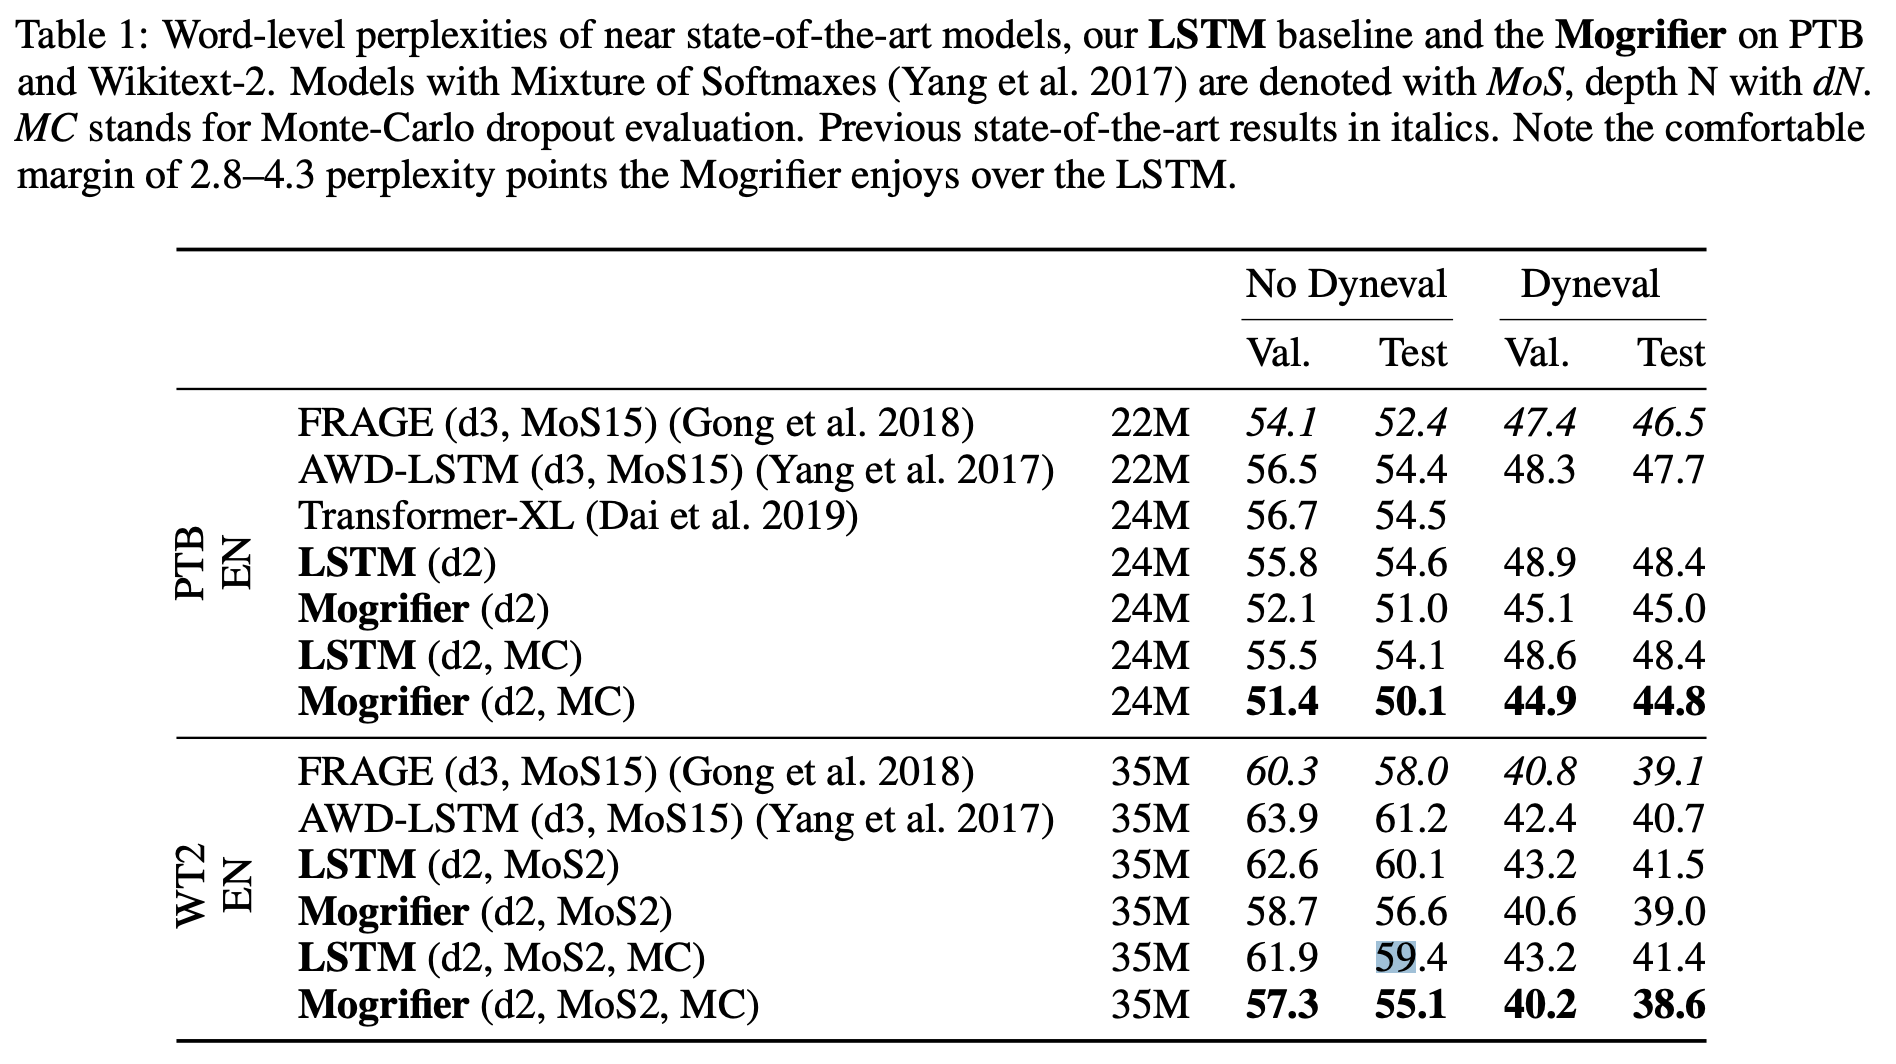

The model is optimized using a black-box hyperparameter tuner from Google Vizier based on [batched Gaussian Process Bandits](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46180.pdf). The following parameters were tuned for the Mogrifier LSTM:

1. _input_embedding_ratio_
2. _learning_rate_
3. _l2_penalty_
4. _input_dropout_
5. _inter_layout_dropout_
6. _state_dropout_
7. _output_dropout_
8. _number_of_mogrifier_rounds_r_
9. _rank_k_ of the low-rank approximation.

## PyTorch Implementation

Next we'll try to implement and reproduce some of the results from the paper. There's an excellent [repo](https://github.com/fawazsammani/mogrifier-lstm-pytorch) with an implementation of the mogrifier LSTM cell which we will build on to attempt to reproduce the paper results. 

In [2]:
import torch
import torch.nn as nn
import math
from torchtext.datasets import WikiText2

train_iter, test_iter, val_iter = WikiText2.iters(batch_size=64, bptt_len=70)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


time: 981 ms


Next we'll create the Mogrifier LSTM Cell and the Model class from the linked repo.

In [3]:
class MogrifierLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, mogrify_steps):
        super(MogrifierLSTMCell, self).__init__()
        self.mogrify_steps = mogrify_steps
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.mogrifier_list = nn.ModuleList([nn.Linear(hidden_size, input_size)])  # start with q
        for i in range(1, mogrify_steps):
            if i % 2 == 0:
                self.mogrifier_list.extend([nn.Linear(hidden_size, input_size)])  # q
            else:
                self.mogrifier_list.extend([nn.Linear(input_size, hidden_size)])  # r
   
    def mogrify(self, x, h):
        for i in range(self.mogrify_steps):
            if (i+1) % 2 == 0: 
                h = (2*torch.sigmoid(self.mogrifier_list[i](x))) * h
            else:
                x = (2*torch.sigmoid(self.mogrifier_list[i](h))) * x
        return x, h

    def forward(self, x, states):
        ht, ct = states
        x, ht = self.mogrify(x, ht)
        ht, ct = self.lstm(x, (ht, ct))
        return ht, ct

time: 2.12 ms


In [16]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, mogrify_steps, vocab_size, tie_weights, dropout):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.mogrifier_lstm_layer1 = MogrifierLSTMCell(input_size, hidden_size, mogrify_steps)
        self.mogrifier_lstm_layer2 = MogrifierLSTMCell(hidden_size, hidden_size, mogrify_steps)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.drop = nn.Dropout(dropout)
        if tie_weights:
            self.fc.weight = self.embedding.weight
            
        self.device = torch.device("cuda" if torch.cuda.is_available() else
                           "cpu")
        
    def forward(self, seq):
        
        embed = self.embedding(seq)
        batch_size = seq.shape[0]
        h1,c1 = [torch.zeros(batch_size,self.hidden_size).to(self.device), 
                 torch.zeros(batch_size,self.hidden_size).to(self.device)]
        h2,c2 = [torch.zeros(batch_size,self.hidden_size).to(self.device), 
                 torch.zeros(batch_size,self.hidden_size).to(self.device)]
        hidden_states = []
        outputs = []
        max_len = seq.size(-1)
        for step in range(max_len):
            x = self.drop(embed[:, step])
            h1,c1 = self.mogrifier_lstm_layer1(x, (h1, c1))
            h2,c2 = self.mogrifier_lstm_layer2(h1, (h2, c2))
            out = self.fc(self.drop(h2))
            hidden_states.append(h2.unsqueeze(1))
            outputs.append(out.unsqueeze(1))
            

        hidden_states = torch.cat(hidden_states, dim = 1)   # (batch_size, max_len, hidden_size)
        outputs = torch.cat(outputs, dim = 1)               # (batch_size, max_len, vocab_size)
        
        return outputs, hidden_states 

time: 3.12 ms


### Create Training & Eval Loops.

In [27]:
class Trainer:
    """AutoEncoder Training class."""
    def __init__(self, model, optimizer, criterion, train_loader, test_loader): 
        """Initialization."""
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else
                                   "cpu")
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.test_loader = test_loader
        
    def train_iter(self):
        """Single pass through the training data."""
        self.model.train()
        train_loss = 0
        for batch in self.train_loader:
            batch.text = batch.text.to(self.device).t()
            batch.target = batch.target.to(self.device).t()
            self.optimizer.zero_grad()
            output, _ = self.model(batch.text)
            loss = self.criterion(output.view(-1, output.size(-1)),
                                  batch.target.contiguous().view(-1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10)
            train_loss += loss.item()
            self.optimizer.step()
        
        return train_loss / len(self.train_loader)
    
    def test_iter(self):
        """Single pass through the test set."""
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in self.test_loader:
                batch.text = batch.text.to(self.device).t()
                batch.target = batch.target.to(self.device).t()
                output, _ = self.model(batch.text)
                test_loss += self.criterion(output.view(-1, output.size(-1)),
                                            batch.target.contiguous().view(-1))

        return test_loss / len(self.test_loader)
    
    def train_and_evaluate(self, epochs):
        """Run training and evaluation."""
        self.model.to(self.device)
        test_losses = []
        for epoch in range(epochs):
            train_loss = self.train_iter()
            test_losses.append(self.test_iter())
            
            print(f"\tEpoch: {epoch}, Train Loss: {train_loss:.4f}," 
                  f"Test Loss: {test_losses[-1]:.4f}",
                  f"Train Perplexity: {math.exp(train_loss)}",
                  f"Test Perplexity: {math.exp(test_losses[epoch])}")

time: 3.66 ms


In [30]:
input_size = 512
hidden_size = 512
vocab_size = len(train_iter.dataset.fields['text'].vocab)
batch_size = 64
lr = 3e-3
mogrify_steps = 5        # 5 steps give optimal performance according to the paper
dropout = 0.5            # for simplicity: input dropout and output_dropout are 0.5. See appendix B in the paper for exact values
tie_weights = True       # in the paper, embedding weights and output weights are tied
betas = (0, 0.999)       # in the paper the momentum term in Adam is ignored
weight_decay = 2.5e-4    # weight decay is around this value, see appendix B in the paper
clip_norm = 10           # paper uses cip_norm of 10

model = Model(input_size, hidden_size, mogrify_steps, vocab_size, tie_weights, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=1e-08, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, criterion, train_iter, val_iter)

time: 288 ms


In [31]:
trainer.train_and_evaluate(10)

	Epoch: 0, Train Loss: 7.3795,Test Loss: 6.4859 Train Perplexity: 1602.7527736546363 Test Perplexity: 655.8395284113902
	Epoch: 1, Train Loss: 6.5023,Test Loss: 5.9144 Train Perplexity: 666.6437675682724 Test Perplexity: 370.33825473941175
	Epoch: 2, Train Loss: 5.8934,Test Loss: 5.6523 Train Perplexity: 362.64135021578414 Test Perplexity: 284.95855538715824
	Epoch: 3, Train Loss: 5.5355,Test Loss: 5.5896 Train Perplexity: 253.53940501435957 Test Perplexity: 267.64082129868837
	Epoch: 4, Train Loss: 5.4095,Test Loss: 5.4894 Train Perplexity: 223.5173917115088 Test Perplexity: 242.11857040785088
	Epoch: 5, Train Loss: 5.3550,Test Loss: 5.4709 Train Perplexity: 211.66582284318775 Test Perplexity: 237.67152381077972
	Epoch: 6, Train Loss: 5.3208,Test Loss: 5.4524 Train Perplexity: 204.55458397586682 Test Perplexity: 233.32518148763725
	Epoch: 7, Train Loss: 5.2981,Test Loss: 5.4780 Train Perplexity: 199.94832110307067 Test Perplexity: 239.37643563083174
	Epoch: 8, Train Loss: 5.2835,Test 